**Supervised Learning Models: Predictions**

In [12]:

# 📚 Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap
import matplotlib.pyplot as plt


In [13]:
# Read UK raw data for labelling the cols
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')
# Read US scaled data
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_raw_data.csv')

# Print shape of each DataFrame
UK_data = UK_data.drop(['longitude', 'latitude'], axis=1)


print("UK shape:", UK_data.shape)
print("US shape:", US_data.shape)



/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_2278/3102222315.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')


UK shape: (229782, 21)
US shape: (4159, 21)


In [14]:
# 🧹 Make sure both have a binary target column called 'severity'
# Assume: severity = 1 if fatal/severe, 0 otherwise
# Make sure to preprocess these before use (drop NA, encode categoricals, etc.)

# UK_df_scaled.head()
# US_df_scaled.head()
# we have to rescale these as we must merge the accidents into binary
print(UK_data['Highest Injury Severity Alleged'].unique())
print(US_data['Highest Injury Severity Alleged'].unique())

['Minor' 'Serious' 'Fatality']
['No Injuries Reported' 'Minor' 'Serious' 'Moderate' 'Fatality']


In [15]:
# For UK Dataset
UK_data['Highest Injury Severity Alleged'] = UK_data['Highest Injury Severity Alleged'].apply(lambda x: 0 if x == 'Minor' else 1)

# For US Dataset
def map_us_severity(x):
    if x in ['No Injuries Reported', 'Minor']:
        return 0
    else:  # Serious or Fatality
        return 1

US_data['Highest Injury Severity Alleged'] = US_data['Highest Injury Severity Alleged'].apply(map_us_severity)
# note uk data has no 'no induries hence we will binary minor and no injuries together 
# and serious, moderarte and fatality together as minor/no injury and serious/fatalities
print(UK_data['Highest Injury Severity Alleged'].unique())
print(US_data['Highest Injury Severity Alleged'].unique())

[0 1]
[0 1]


In [16]:
# reencode and scale 
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import pandas as pd

# Define your columns (fixed syntax errors and duplicates)
categorical_columns = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area'# Note: This should be numerical but included here for encoding
]

datetime_cols = ['Incident Date', 'Incident Time (24:00)']
numerical_cols = []  # Add any truly numerical columns here
index_cols = ['Report ID', 'Report Version']

US_categorical_cols = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area'# Note: This should be numerical but included here for encoding
]

UK_categorical_cols = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State',
    'Make', 'Model', 'Model Year', 
    'Posted Speed Limit (MPH)','SV Pre-Crash Movement', 'SV Contact Area' # Note: This should be numerical but included here for encoding
]

# === Define columns ===
categorical_columns = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State','Country','Report ID', 'Report Version',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area','Crash With'
]

datetime_cols = ['Incident Date', 'Incident Time (24:00)']
numerical_cols = []  # Add real numerical columns here if any


def encode_data(df, categorical_cols, datetime_cols, numerical_cols, index_cols):
    """
    Encodes categorical columns using LabelEncoder and datetime columns as numeric values.
    """
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd

    df_encoded = df.copy()
    encoders = {}

    # Encode categorical columns
    for col in categorical_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype(str).fillna("Unknown")
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoders[col] = le

    # Convert datetime columns to numeric formats
    if 'Incident Date' in datetime_cols and 'Incident Date' in df_encoded.columns:
        df_encoded['Incident Date'] = pd.to_datetime(df_encoded['Incident Date'], errors='coerce')
        df_encoded['Incident_Year'] = df_encoded['Incident Date'].dt.year
        df_encoded['Incident_Month'] = df_encoded['Incident Date'].dt.month
        df_encoded['Incident_DayOfWeek'] = df_encoded['Incident Date'].dt.dayofweek
        df_encoded.drop(columns=['Incident Date'], inplace=True)

    if 'Incident Time (24:00)' in datetime_cols and 'Incident Time (24:00)' in df_encoded.columns:
        time_parsed = pd.to_datetime(df_encoded['Incident Time (24:00)'], format='%H:%M:%S', errors='coerce')
        df_encoded['Incident Time (24:00)'] = (
            time_parsed.dt.hour.fillna(0).astype(int) * 3600 +
            time_parsed.dt.minute.fillna(0).astype(int) * 60 +
            time_parsed.dt.second.fillna(0).astype(int)
        )


    return df_encoded, encoders


# === Encode both datasets ===
US_encoded_df, us_encoders = encode_data(
    df=US_data, # already imputed
    categorical_cols=categorical_columns,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

UK_encoded_df, uk_encoders = encode_data(
    df=UK_data,
    categorical_cols=categorical_columns,
    datetime_cols=datetime_cols,
    numerical_cols=numerical_cols,
    index_cols=index_cols
)

# === Preview ===
print("US Data Shape:", US_encoded_df.shape)
print("UK Data Shape:", UK_encoded_df.shape)
print("\nUK Preview:")
print(tabulate(UK_encoded_df.head(), headers='keys', tablefmt='pretty'))

print("\nUS Preview:")
print(tabulate(US_encoded_df.head(), headers='keys', tablefmt='pretty'))

US Data Shape: (4159, 23)
UK Data Shape: (229782, 23)

UK Preview:
+---+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+------+-------+--------------+-----------------+--------------------------+----------+------------+---------------------------------+-----------------------+---------+-----------------+---------+---------------+----------------+--------------------+
|   | Report ID | Report Version | Make | Model | Model Year | ADS Equipped? | Automation System Engaged? | Incident Time (24:00) | City | State | Roadway Type | Roadway Surface | Posted Speed Limit (MPH) | Lighting | Crash With | Highest Injury Severity Alleged | SV Pre-Crash Movement | Weather | SV Contact Area | Country | Incident_Year | Incident_Month | Incident_DayOfWeek |
+---+-----------+----------------+------+-------+------------+---------------+----------------------------+-----------------------+------+-------+--------------+----------

In [17]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import pandas as pd

def scale_and_preview(df_US, df_UK, scaler_type='standard', exclude_columns=None):
    """
    Scale two dataframes (e.g., US and UK) using StandardScaler or MinMaxScaler,
    while excluding specified columns from scaling. Prints their shapes and head previews.
    
    Parameters:
    - df_US, df_UK: DataFrames to scale
    - scaler_type: 'standard' or 'minmax'
    - exclude_columns: list of column names to exclude from scaling
    """
    if exclude_columns is None:
        exclude_columns = []

    # Choose the scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaler_type must be 'standard' or 'minmax'")

    # Separate columns to scale
    US_to_scale = df_US.drop(columns=exclude_columns)
    UK_to_scale = df_UK.drop(columns=exclude_columns)

    # Scale
    US_scaled = scaler.fit_transform(US_to_scale)
    UK_scaled = scaler.transform(UK_to_scale)

    # Reconstruct scaled DataFrames
    US_scaled_df = pd.DataFrame(US_scaled, columns=US_to_scale.columns, index=df_US.index)
    UK_scaled_df = pd.DataFrame(UK_scaled, columns=UK_to_scale.columns, index=df_UK.index)

    # Add back excluded columns
    for col in exclude_columns:
        US_scaled_df[col] = df_US[col].values
        UK_scaled_df[col] = df_UK[col].values

    # Reorder columns to match original
    US_scaled_df = US_scaled_df[df_US.columns]
    UK_scaled_df = UK_scaled_df[df_UK.columns]

    # Preview
    print("US Data Shape:", US_scaled_df.shape)
    print("UK Data Shape:", UK_scaled_df.shape)

    print("\nUK Preview:")
    print(tabulate(UK_scaled_df.head(), headers='keys', tablefmt='pretty'))

    print("\nUS Preview:")
    print(tabulate(US_scaled_df.head(), headers='keys', tablefmt='pretty'))

    return US_scaled_df, UK_scaled_df

# Example call
US_scaled_df, UK_scaled_df = scale_and_preview(
    US_encoded_df, UK_encoded_df,
    scaler_type='standard',
    exclude_columns=['Highest Injury Severity Alleged']
)


US Data Shape: (4159, 23)
UK Data Shape: (229782, 23)

UK Preview:
+---+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+----------------------------+-----------------------+---------------------+---------------------+---------------------+----------------------+--------------------------+---------------------+---------------------+---------------------------------+-----------------------+---------------------+---------------------+---------+--------------------+---------------------+----------------------+
|   |      Report ID      |   Report Version   |        Make         |        Model        |     Model Year     |    ADS Equipped?    | Automation System Engaged? | Incident Time (24:00) |        City         |        State        |    Roadway Type     |   Roadway Surface    | Posted Speed Limit (MPH) |      Lighting       |     Crash With      | Highest Injury Severity Alleged | SV Pre-Crash Movement |

In [18]:
US_categorical_cols = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'State',
    'Make', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area'# Note: This should be numerical but included here for encoding
]

UK_categorical_cols = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'State',
    'Make', 'Model Year', 
    'Posted Speed Limit (MPH)','SV Pre-Crash Movement', 'SV Contact Area' # Note: This should be numerical but included here for encoding
]

# Subset to only the specified categorical columns
US_filtered = US_data[US_categorical_cols].copy()
UK_filtered = UK_data[UK_categorical_cols].copy()


In [19]:
# 📊 Shared Evaluation Function
def evaluate_model(y_true, y_pred, y_proba, model_name, dataset_label):
    print(f"\n📊 {model_name} Evaluation on {dataset_label} Dataset")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

### **Logestic Regression**

In [20]:
def run_logistic_regression(df, label="Dataset"):
    print(f"\n🚦 Running Logistic Regression on {label}")
    df = df.dropna()

    X = pd.get_dummies(df.drop("Highest Injury Severity Alleged", axis=1), drop_first=True)
    y = df["Highest Injury Severity Alleged"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=5000, class_weight='balanced')  # Updated
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    evaluate_model(y_test, y_pred, y_proba, "Logistic Regression", label)

    # Coefficient reporting
    print("\n🧠 Coefficients (Logistic Regression):")
    coefs = list(zip(X_train.columns, model.coef_[0]))
    coefs_sorted = sorted(coefs, key=lambda x: abs(x[1]), reverse=True)

    for feature, coef in coefs_sorted:
        direction = "↑ increases" if coef > 0 else "↓ decreases"
        print(f"{feature}: {coef:.3f} → {direction} severity risk")




In [21]:

run_logistic_regression(US_filtered, label="US (Autonomous Driving)")


🚦 Running Logistic Regression on US (Autonomous Driving)

📊 Logistic Regression Evaluation on US (Autonomous Driving) Dataset
Accuracy: 0.7284552845528456
Precision: 0.2696078431372549
Recall: 0.7534246575342466
F1 Score: 0.3971119133574007
ROC AUC: 0.8079032502653793
Confusion Matrix:
 [[393 149]
 [ 18  55]]

🧠 Coefficients (Logistic Regression):
SV Contact Area_Back, Front: -1.927 → ↓ decreases severity risk
Make_Jaquar: 1.738 → ↑ increases severity risk
State_CT : -1.658 → ↓ decreases severity risk
SV Contact Area_Offside: -1.585 → ↓ decreases severity risk
Make_NISSAN: 1.541 → ↑ increases severity risk
Make_Cruise: 1.504 → ↑ increases severity risk
Make_Toyota: -1.473 → ↓ decreases severity risk
State_MD : 1.452 → ↑ increases severity risk
Make_KIA: 1.441 → ↑ increases severity risk
SV Contact Area_Back, Bottom, Front, Nearside, Offside, Top: 1.411 → ↑ increases severity risk
Make_Ford: 1.338 → ↑ increases severity risk
Roadway Type_Traffic Circle: 1.322 → ↑ increases severity ris

In [22]:
run_logistic_regression(UK_filtered, label="UK (Human Driving)")



🚦 Running Logistic Regression on UK (Human Driving)

📊 Logistic Regression Evaluation on UK (Human Driving) Dataset
Accuracy: 0.5648105838066019
Precision: 0.2797955831356087
Recall: 0.5925782759953614
F1 Score: 0.3801140590131416
ROC AUC: 0.6094892340610067
Confusion Matrix:
 [[19825 15784]
 [ 4216  6132]]

🧠 Coefficients (Logistic Regression):
SV Pre-Crash Movement_Waiting to go - held up: -1.151 → ↓ decreases severity risk
SV Pre-Crash Movement_Waiting to turn left: -0.950 → ↓ decreases severity risk
SV Pre-Crash Movement_Stopping: -0.792 → ↓ decreases severity risk
Make_TESLA: -0.640 → ↓ decreases severity risk
State_Scotland: 0.636 → ↑ increases severity risk
SV Contact Area_Nearside: 0.546 → ↑ increases severity risk
SV Contact Area_Did not impact: 0.541 → ↑ increases severity risk
SV Contact Area_Front: 0.516 → ↑ increases severity risk
SV Contact Area_Offside: 0.486 → ↑ increases severity risk
SV Pre-Crash Movement_Waiting to turn right: -0.454 → ↓ decreases severity risk
SV P

### **Random Forest**

In [23]:
# 🌲 Random Forest
def run_random_forest(df, label="Dataset"):
    print(f"\n🌲 Running Random Forest on {label}")
    df = df.dropna()
    X = pd.get_dummies(df.drop("Highest Injury Severity Alleged", axis=1), drop_first=True)
    y = df["Highest Injury Severity Alleged"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    evaluate_model(y_test, y_pred, y_proba, "Random Forest", label)

# 🔹 Random Forest
run_random_forest(UK_filtered, label="UK (Human Driving)")
run_random_forest(US_filtered, label="US (Autonomous Driving)")


🌲 Running Random Forest on UK (Human Driving)

📊 Random Forest Evaluation on UK (Human Driving) Dataset
Accuracy: 0.7295515373066127
Precision: 0.2784756227379178
Recall: 0.12640123695400077
F1 Score: 0.17387836490528416
ROC AUC: 0.5505801231524154
Confusion Matrix:
 [[32220  3389]
 [ 9040  1308]]

🌲 Running Random Forest on US (Autonomous Driving)

📊 Random Forest Evaluation on US (Autonomous Driving) Dataset
Accuracy: 0.8764227642276423
Precision: 0.46153846153846156
Recall: 0.2465753424657534
F1 Score: 0.32142857142857145
ROC AUC: 0.8480134458878835
Confusion Matrix:
 [[521  21]
 [ 55  18]]


In [26]:
def run_xgboost(df, label="Dataset"):
    print(f"\n⚡ Running XGBoost on {label}")

    # Step 1: Clean data
    df = df.dropna().reset_index(drop=True)
    X = pd.get_dummies(df.drop("Highest Injury Severity Alleged", axis=1), drop_first=True)
    y = df["Highest Injury Severity Alleged"]

    # Step 2: Drop remaining problematic columns (non-numeric)
    X = X.apply(pd.to_numeric, errors='coerce')  # force all to numeric
    X = X.dropna(axis=1)  # drop columns with NaNs after conversion

    # Step 3: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 4: Ensure float dtype for SHAP/XGBoost
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)

    # Step 5: Train model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Step 6: Evaluate
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    evaluate_model(y_test, y_pred, y_proba, "XGBoost", label)

    # Step 7: SHAP Explanation
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    print(f"\n📈 SHAP Summary Plot for {label}")
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Feature Importance - {label}")
    plt.show()




⚡ Running XGBoost on US (Autonomous Driving)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Evaluation on US (Autonomous Driving) Dataset
Accuracy: 0.8764227642276423
Precision: 0.4594594594594595
Recall: 0.2328767123287671
F1 Score: 0.3090909090909091
ROC AUC: 0.8531441136329171
Confusion Matrix:
 [[522  20]
 [ 56  17]]

📈 SHAP Summary Plot for US (Autonomous Driving)


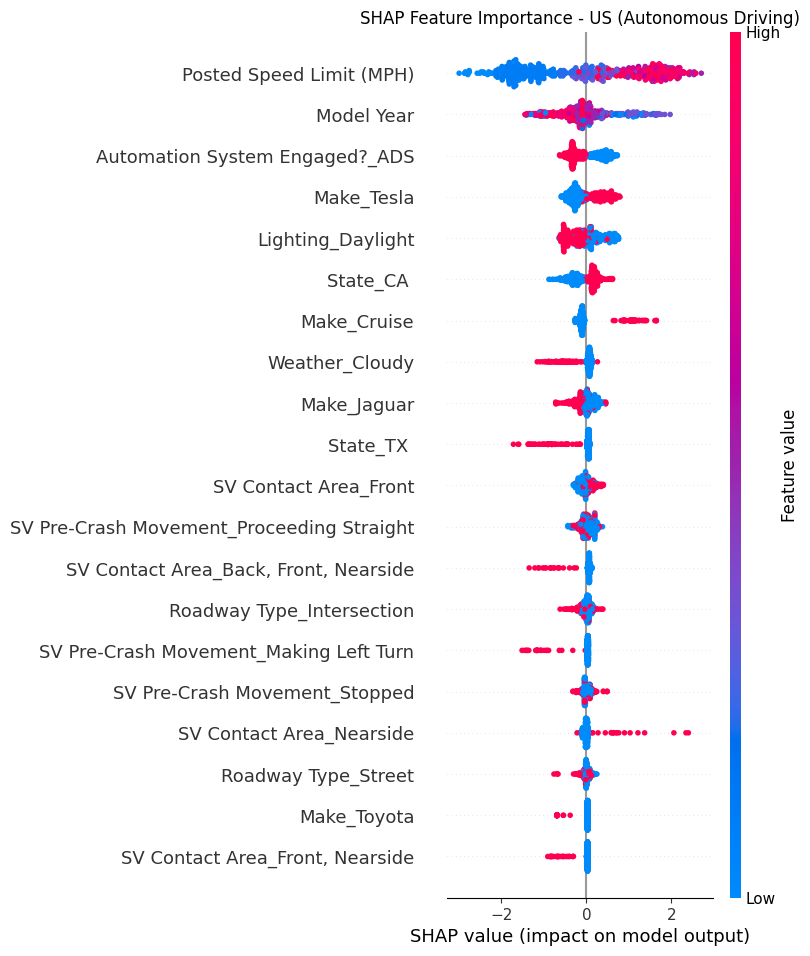

In [27]:

run_xgboost(US_filtered, label="US (Autonomous Driving)")


⚡ Running XGBoost on UK (Human Driving)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Evaluation on UK (Human Driving) Dataset
Accuracy: 0.7742890092912941
Precision: 0.4592833876221498
Recall: 0.013625821414766138
F1 Score: 0.02646644767714688
ROC AUC: 0.6059092824122514
Confusion Matrix:
 [[35443   166]
 [10207   141]]


100%|===================| 45796/45957 [01:37<00:00]        


📈 SHAP Summary Plot for UK (Human Driving)


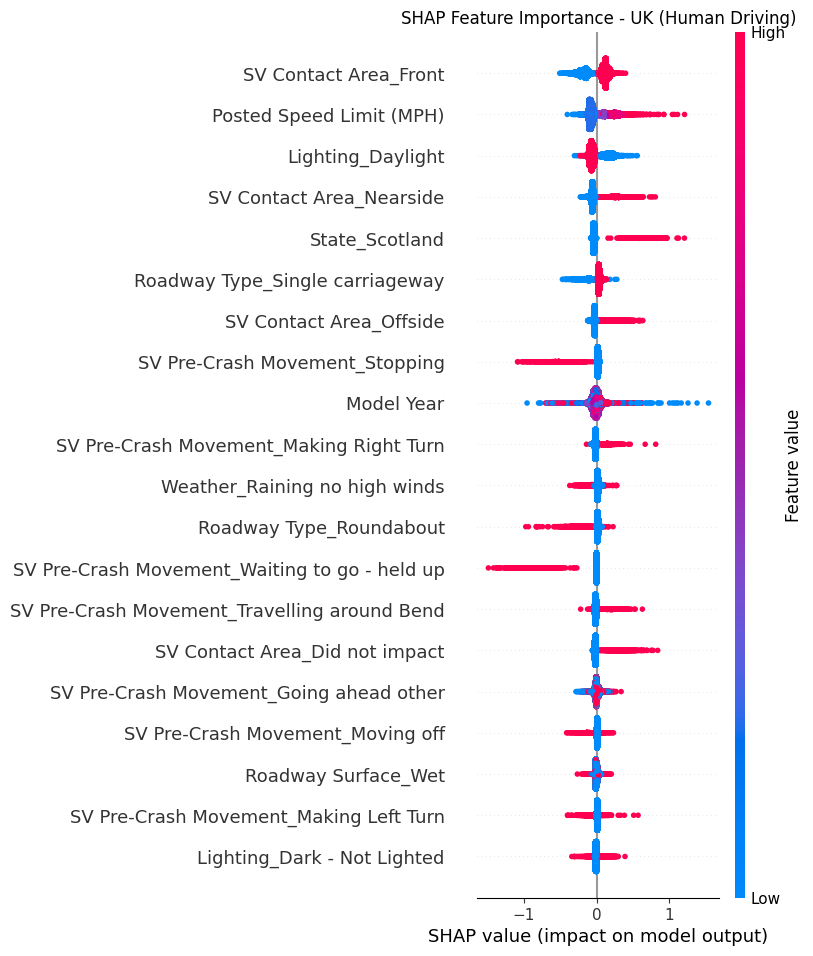

In [28]:
# 🔹 XGBoost
run_xgboost(UK_filtered, label="UK (Human Driving)")